In [2]:
'''
Inspired from https://github.com/GunhoChoi/Kind-PyTorch-Tutorial/blob/master/07_Denoising_Autoencoder/Denoising_Autoencoder.ipynb
'''

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io, transform
import os
import pickle
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [4]:
filename='data/NZ_del20.pkl' #deleted 20% images with lower NZ count
with open(filename, 'rb') as handle:
    subset_dict=pickle.load(handle)
images_list=subset_dict['images']
GO_terms=subset_dict['GO_terms']
gene_id=subset_dict['gene_id']
del subset_dict


In [5]:
#reshape images to same dimensions
from skimage.transform import resize
data_list=[]
for gray_img in images_list:
    img=resize(gray_img, (120,240), anti_aliasing=True, mode='constant') #resize all images to 120x240
    img=np.asarray(img, dtype=float)
    data_list.append(img)

images_array=np.asarray(data_list)
del data_list, images_list

In [6]:
class Comb_Dataset(Dataset):

    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        sample = {'image': image}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        transformed_image = torch.from_numpy(image)
        unsqueezed_image = torch.unsqueeze(transformed_image,0) #add a dimension with value 1 to represent colour
        float_img=unsqueezed_image.float()
        return {'image': float_img}


In [7]:
#preparing the data and batches
transformed_data = Comb_Dataset(images = images_array, 
                                transform = ToTensor())
del images_array

In [8]:
class SmallEncoder(nn.Module):
    def __init__(self):
        super(SmallEncoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.layer3 = nn.Sequential(
                        nn.Conv2d(16,16,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
                        nn.Conv2d(16,1,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(1),
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out, indices1 = self.pool(out)
        out = self.layer2(out)
        out, indices2 = self.pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out, [indices1, indices2]

encoder = SmallEncoder().to(device)


class SmallDecoder(nn.Module):
    def __init__(self):
        super(SmallDecoder,self).__init__()
        self.first_conv = nn.Sequential(
                        nn.ConvTranspose2d(1,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.unpool = nn.MaxUnpool2d(2,2)
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(16,1,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(1),
        )
        
    def forward(self,x, indices):
        out = x.view(x.size(0),1,30,60)
        out = self.first_conv(out)
        out = self.unpool(out, indices[1])
        out = self.layer1(out)
        out = self.unpool(out, indices[0])
        out = self.layer2(out)
        out = self.layer3(out)
        return out

decoder = SmallDecoder().to(device)

In [8]:
# Encoder 

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.layer3 = nn.Sequential(
                        nn.Conv2d(16,16,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
                        nn.Conv2d(16,1,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(1),
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out, indices1 = self.pool(out)
        out = self.layer2(out)
        out, indices2 = self.pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out, [indices1, indices2]

encoder = Encoder().to(device)


In [9]:
# Decoder 

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.first_conv = nn.Sequential(
                        nn.ConvTranspose2d(1,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.unpool = nn.MaxUnpool2d(2,2)
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(16,1,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(1),
        )
        
    def forward(self,x, indices):
        out = x.view(x.size(0),1,30,60)
        out = self.first_conv(out)
        out = self.unpool(out, indices[1])
        out = self.layer1(out)
        out = self.unpool(out, indices[0])
        out = self.layer2(out)
        out = self.layer3(out)
        return out

decoder = Decoder().to(device)

In [10]:
# save and load model

try:
    encoder, decoder, cur_epoch = torch.load('./data/deno_autoencoder.pkl', map_location='cpu')
#    encoder, decoder, cur_epoch = torch.load('./data/deno_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass



--------model restored--------



In [11]:
batch_size =30

#preparing the data and batches
train_loader = torch.utils.data.DataLoader(transformed_data, batch_size=batch_size, shuffle=True)
del transformed_data

In [ ]:
orig_batches=[]
out_batches=[]
i=0
with torch.no_grad():
    for batch_idx, data in enumerate(train_loader):
        image = data["image"].to(device)
        orig_batches.append(image)
        enc_output, indices = encoder(image)
        output=decoder(enc_output, indices)
        out_batches.append(output)
        print(i)


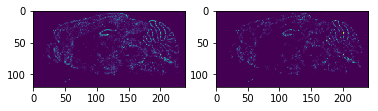

In [34]:
images=orig_batches[0].cpu().numpy()
recoded=out_batches[0].cpu().numpy()
i=15
fig,[ax1,ax2]=plt.subplots(1,2)
ax1.imshow(images[i,0,:,:])
ax2.imshow(recoded[i,0,:,:])
#fig.savefig('enc_recover_ex5.pdf')

In [ ]:
orig_batches=[]
enc_batches=[]
i=0
with torch.no_grad():
    for batch_idx, data in enumerate(train_loader):
        image = data["image"].to(device)
        orig_batches.append(image)
        enc_output, indices = encoder(image)
        enc_batches.append(enc_output)
        print(i)
        i+=1


In [62]:
filename='data/enc_batches.pkl'
with open(filename, 'wb') as handle:
    pickle.dump([orig_batches, enc_batches], handle)


In [2]:
filename='data/enc_batches.pkl'
with open(filename, 'rb') as handle:
    [orig_batches, enc_batches]=pickle.load(handle)


In [3]:
enc_features=[]
for batch in enc_batches:
    for i in range(batch.size(0)):
        enc_features.append(batch.numpy()[i,:])
enc_features=np.asarray(enc_features)

In [4]:
orig_img=[]
for batch in orig_batches:
    for i in range(batch.size(0)):
        orig_img.append(batch.numpy()[i,0,:,:])
orig_img=np.asarray(orig_img)

In [5]:
del orig_batches, enc_batches

In [12]:
filename='data/enc_features.pkl'
with open(filename, 'wb') as handle:
    pickle.dump(enc_features, handle)

In [14]:
filename='data/enc_features.pkl'
with open(filename, 'rb') as handle:
    enc_features=pickle.load(handle)


###Visualize if similarity in features is a proxy for similar expression profiles

In [138]:
#img=image.detach().numpy().squeeze()
data=enc_features
distances=[]
pairs=[]
for i in range(1,1000):
    for j in range(i):
        a=data[i,:].reshape(-1)
        b=data[j,:].reshape(-1)
        dist=np.corrcoef(a,b)[0,1]
        distances.append(dist)
        pairs.append([i,j])
    if i%100==0:
        print(i)
distances=np.asarray(distances)
pairs=np.asarray(pairs)

100
200
300
400
500
600
700
800
900


In [139]:
best_idx=np.argsort(distances)[-100:]
best_pairs=pairs[best_idx,:]


0.8783742097025797
[855 614]


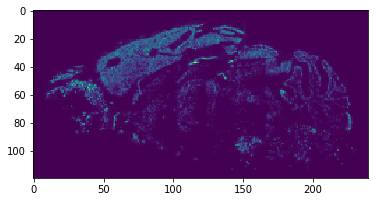

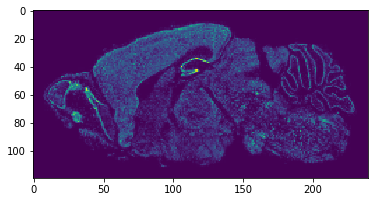

In [145]:
pair=pairs[best_idx[35],:]
print(distances[best_idx[35]])
print(pair)
plt.imshow(orig_img[pair[0],:,:])
plt.figure()
plt.imshow(orig_img[pair[1],:,:])

##look if same gene id gives higher similarity

In [157]:
gene_id
data=enc_features
same_gene_correlations=[]
dif_gene_correlations=[]
for i in range(1,10000):
    for j in range(i):
        if gene_id[i]==gene_id[j]:
            a=data[i,:].reshape(-1)
            b=data[j,:].reshape(-1)
            dist=np.corrcoef(a,b)[0,1]
            same_gene_correlations.append(dist)
for i in range(1,1000):
    for j in range(i):
        if not gene_id[i]==gene_id[j]:
            a=data[i,:].reshape(-1)
            b=data[j,:].reshape(-1)
            dist=np.corrcoef(a,b)[0,1]
            dif_gene_correlations.append(dist)
    if i%100==0:
        print(i)
same_gene_correlations=np.asarray(same_gene_correlations)
dif_gene_correlations=np.asarray(dif_gene_correlations)


100
200
300
400
500
600
700
800
900


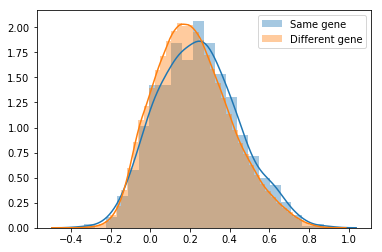

In [160]:
import seaborn as sns
sns.distplot(same_gene_correlations);
sns.distplot(dif_gene_correlations);
plt.legend(['Same gene', 'Different gene'])
plt.savefig('enc_geneSim_corr.pdf')


###determine if GO categories result in more features similarity

In [161]:
'''
PICK THE GO TERMS THAT SHOW UP IN BETWEEN 15 and 500 Slices
'''
def get_15to500_GO(GO_terms):
    GO_annotations_nb = {}
    for GO_list in GO_terms:
        for GO_term in GO_list:
            if GO_term in GO_annotations_nb:
                GO_annotations_nb[GO_term] += 1
            else:
                GO_annotations_nb[GO_term] = 1

    list15to500GO = []
    list15to500values = []
    for GO in GO_annotations_nb.keys():
        if GO_annotations_nb[GO] >= 15 and GO_annotations_nb[GO] <= 50:
            list15to500GO.append(GO)
            list15to500values.append(GO_annotations_nb[GO])

    GO_list=[]
    for GO_term in list15to500GO:
        image_list=[]
        for image_GO in GO_terms:
            if GO_term in image_GO:
                image_list.append(1)
            else:
                image_list.append(0)
        GO_list.append(image_list)
    return np.asarray(GO_list), list15to500values


In [162]:
[GO_term_array, list15to500values]=get_15to500_GO(GO_terms)

In [ ]:
data=enc_features
same_GO_correlations=[]
dif_GO_correlations=[]
GO_sims=[]
for i in range(1,1000):
    for j in range(i):
        img_GO=GO_term_array[:,i]
        idx_1=(img_GO==1)
        img_GO=GO_term_array[:,j]
        idx_2=(img_GO==1)
        if np.sum(idx_1*idx_2)>0:
            continue
        else:
            a=data[i,:].reshape(-1)
            b=data[j,:].reshape(-1)
            dist=np.corrcoef(a,b)[0,1]
            dif_GO_correlations.append(dist)
    if i%100==0:
        print(i)
for i in range(1,3000):
    for j in range(i):
        #evaluating similarity based on proportion of GO annotations that are shared
        img_GO=GO_term_array[:,i]
        idx_1=(img_GO==1)
        img_GO=GO_term_array[:,j]
        idx_2=(img_GO==1)
        if np.sum(idx_1*idx_2)>0:
            GO_sim=np.sum(idx_1*idx_2)/(np.sum(idx_1)+np.sum(idx_2))
            GO_sims.append(GO_sim)
            a=data[i,:].reshape(-1)
            b=data[j,:].reshape(-1)
            dist=np.corrcoef(a,b)[0,1]
            same_GO_correlations.append(dist)
        else:
            continue
    if i%100==0:
        print(i)
GO_sims=np.asarray(GO_sims)
same_GO_correlations=np.asarray(same_GO_correlations)
dif_GO_correlations=np.asarray(dif_GO_correlations)


In [ ]:
import seaborn as sns
sns.distplot(same_GO_correlations);
sns.distplot(dif_GO_correlations);
plt.legend(['At least 1 GO in common', 'No common GO'])
plt.savefig('enc_GOSim_corr.pdf')
print(same_GO_correlations.mean())
print(dif_GO_correlations.mean())


0.22183969437489398
0.2141235405689341


####PREDICTIONS

In [85]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
def kfold(X,Y, model, n_splits):
    skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)
    k_fold_scores=[]
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model.fit(X_train,Y_train)
        Y_pred=model.predict(X_test)
        score = metrics.roc_auc_score(Y_test, Y_pred)
        k_fold_scores.append(score)
    return np.asarray(k_fold_scores)

In [81]:
#make a list of 100 random GO index
length=GO_term_array.shape[0]
import random
idx_list=random.sample(range(0, length), 100)

import csv

csvfile='random_GO_idx.csv'
#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in idx_list:
        writer.writerow([val])

In [28]:
#load the results from randomized search
files=os.listdir('data/rs/')
rs_GO_list=[]
for file in files:
    filename='data/rs/%s' % (str(file))
    try:
        with open(filename, 'rb') as handle:
            data=pickle.load(handle)
        rs_GO_list.append(data)
    except:
        continue

rs_data=[]
for data in rs_GO_list:
    dictlist=[]
    for key, value in data.items():
        temp = value
        dictlist.append(temp)
    rs_data.append(dictlist)
rs_data=np.asarray(rs_data)

concat_rs=[]
for key in range(rs_data.shape[1]):
    concat_rs.append(rs_data[:,key,:].reshape(-1))
    

In [75]:
#print the mean performances for different hyperparameters
penalties=['l1', 'l2']
reg_params=[0.001,0.01,0.1,1,10]
for reg_param in reg_params:
    for penalty in penalties:
        idx=np.where(((concat_rs[0]==reg_param) * (concat_rs[1]==penalty)))
        print(penalty+' '+str(reg_param)+' '+str(concat_rs[2][idx].mean()))


l1 0.001 0.5002022576000026
l2 0.001 0.5079043804123374
l1 0.01 0.5065938206698627
l2 0.01 0.5092067420665267
l1 0.1 0.5091809809192755
l2 0.1 0.5099956793425522
l1 1 0.5071662921860483
l2 1 0.5115486433834765
l1 10 0.506980102774704
l2 10 0.5116834219195909


In [128]:
#make a list of chunks of 10 GO index to run in parallel
length=GO_term_array.shape[0]
chunk_list=[]
for i in range(0,length, 10):
    if i+10>length:
        chunk_list.append(np.arange(i, length))
        break
    chunk_list.append(np.arange(i, i+10))

filename='GO_chunk.pkl'
with open(filename, 'wb') as handle:
    pickle.dump(chunk_list, handle)

idx_list=np.arange(0,len(chunk_list))

import csv
csvfile='chunk_GO_idx.csv'
#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in idx_list:
        writer.writerow([val])
        


In [15]:
#load the results from randomized search
files=os.listdir('data/pred/')
GO_scores=[]
for file in files:
    filename='data/pred/%s' % (str(file))
    with open(filename, 'rb') as handle:
        data=pickle.load(handle)
    GO_scores.append(data)

In [26]:
temp=[]
for i in GO_scores:
    for j in i:
        temp.append(j[0])
temp=np.asarray(temp)
        

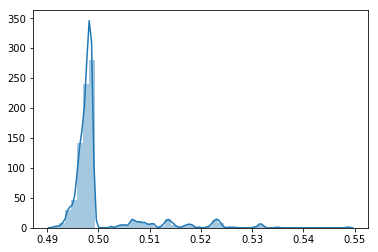

In [36]:
#
import seaborn as sns
sns.distplot(temp.mean(axis=1));
